In [1]:
import numpy as np
import matplotlib.pyplot as pl
import json
from sklearn.utils import class_weight
import tensorflow as tf
from tensorflow.keras import Sequential, activations, Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    BatchNormalization, Activation, SpatialDropout2D, GlobalAveragePooling2D,
    Dense, Dropout, Flatten,
    Conv2D, MaxPooling2D, SeparableConv2D
)
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

# Import project utils scripts
import os
import sys

src_path = os.path.abspath(os.path.join('../src/'))

if src_path not in sys.path:
    sys.path.append(src_path)

from statisticsUtils import recall_precision_fscore_from_confusion_matrix
from labelsUtils import Label
from regionUtils import vietnam_labels_coordinates
from rasterUtils import make_dataset_from_raster_files
from convNetUtils import cross_validation, evaluate_model
from visualizationUtils import label_first_detections
from bandUtils import Band

/home/simon/miniconda3/envs/tb/lib/python3.9/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.1-CAPI-1.14.2). Conversions between both will be slow.
  warnings.warn(


In [3]:
NB_TESTS = 4
EPOCHS = 2000
DATA_ROOT_PATH ='../data/'
LABELS_COORDINATES = vietnam_labels_coordinates()

In [4]:
labels = [label for label in Label]

In [5]:
NB_PIXEL_AROUND=4

bands = [
    Band.COASTAL_AEROSOL.value, 
    Band.BLUE.value, 
    Band.GREEN.value, 
    Band.RED.value, 
    Band.NIR.value, 
    Band.SWIR1.value, 
    Band.SWIR2.value, 
]

In [6]:
# Only labels that contains georeferenced points.
labels = [
    Label.COFFEE,
    # NATIVEVEGE, now replaced by Label.DENSE_FOREST
    Label.DENSE_FOREST,
    Label.RUBBER,
    # SEASONAL, now replaced by SEASONAL_AGRICULTURE
    Label.SEASONAL_AGRICULTURE,
    Label.URBAN,
    Label.WATER,
    Label.OTHER_TREE,
    Label.NATIVE_NO_TREE,
    Label.PEPPER,
    # Label.CASSAVA, # /!\ only 4 images
    Label.TEA,
    Label.RICE,
    Label.INTERCROP,
    Label.DECIDUOUS_FOREST,
    # STICK_PEPPER, now replaced by STICK_PEPPER
    Label.STICK_FOR_PEPPER,
    Label.PINE_TREES,
]

In [7]:
dataset_args = dict(
    labels = labels,
    raster_paths = [DATA_ROOT_PATH + 'Vietnam_2017_january_to_april/merged.tif'],
    labels_coordinates_list = [LABELS_COORDINATES],
    nb_pixel_around = NB_PIXEL_AROUND
)

dataset = make_dataset_from_raster_files(**dataset_args)

In [8]:
model_name = "january_to_april_2017_every_labels"

# images have all the same shapes, take the shape of the first image
image_width = len(dataset[0][1][0][0])
image_height = len(dataset[0][1][0])
image_depth = len(bands)
nb_outputs = len(labels)

# Create model
model = Sequential([
    Rescaling(1./2**16, input_shape=(image_width, image_height, image_depth)),
    BatchNormalization(),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=32, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    Conv2D(filters=64, kernel_size=(3, 3), padding="same", activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    SpatialDropout2D(0.25),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(nb_outputs, activation='softmax'),
])

mean_loss, mean_accuracy, histories, conf_matrix = cross_validation(model, dataset, bands, labels, EPOCHS, NB_TESTS, early_stopping=True, with_model_checkpoint=True, model_name=model_name)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 9, 9, 7)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 9, 9, 7)           28        
_________________________________________________________________
conv2d (Conv2D)              (None, 9, 9, 32)          2048      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 9, 9, 32)          9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 3, 3, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 64)          18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 3, 3, 64)          3

345/345 [==============================] - 1s 4ms/step - loss: 0.7405 - accuracy: 0.6044 - val_loss: 1.0416 - val_accuracy: 0.6103
Epoch 97/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0255 - accuracy: 0.5373 - val_loss: 1.1947 - val_accuracy: 0.5723
Epoch 98/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9494 - accuracy: 0.5668 - val_loss: 1.2577 - val_accuracy: 0.5513
Epoch 99/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8732 - accuracy: 0.5575 - val_loss: 1.1252 - val_accuracy: 0.5940
Epoch 100/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8011 - accuracy: 0.5936 - val_loss: 1.1500 - val_accuracy: 0.5868
Epoch 101/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8878 - accuracy: 0.5636 - val_loss: 1.0968 - val_accuracy: 0.5936
Epoch 102/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7574 - accuracy: 0.6016 - val_loss: 1.0545 - val_accuracy: 0.6

345/345 [==============================] - 1s 4ms/step - loss: 0.6997 - accuracy: 0.6344 - val_loss: 1.0150 - val_accuracy: 0.6255
Epoch 209/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9515 - accuracy: 0.5895 - val_loss: 1.1036 - val_accuracy: 0.5911
Epoch 210/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.2498 - accuracy: 0.5120 - val_loss: 1.3950 - val_accuracy: 0.4917
Epoch 211/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8397 - accuracy: 0.5638 - val_loss: 1.1148 - val_accuracy: 0.6034
Epoch 212/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7374 - accuracy: 0.6109 - val_loss: 1.0391 - val_accuracy: 0.6269
Epoch 213/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8572 - accuracy: 0.6067 - val_loss: 1.0655 - val_accuracy: 0.6067
Epoch 214/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9109 - accuracy: 0.5650 - val_loss: 1.0552 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.7143 - accuracy: 0.6166 - val_loss: 0.9859 - val_accuracy: 0.6424
Epoch 99/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8413 - accuracy: 0.5980 - val_loss: 1.0274 - val_accuracy: 0.6258
Epoch 100/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9456 - accuracy: 0.5660 - val_loss: 1.0369 - val_accuracy: 0.6367
Epoch 101/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9782 - accuracy: 0.5387 - val_loss: 1.0607 - val_accuracy: 0.6132
Epoch 102/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8900 - accuracy: 0.5600 - val_loss: 1.0782 - val_accuracy: 0.6059
Epoch 103/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9175 - accuracy: 0.5616 - val_loss: 1.0778 - val_accuracy: 0.6106
Epoch 104/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7122 - accuracy: 0.6045 - val_loss: 1.0672 - val_accuracy: 0

345/345 [==============================] - 1s 4ms/step - loss: 0.8983 - accuracy: 0.5853 - val_loss: 1.0885 - val_accuracy: 0.6168
Epoch 211/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8060 - accuracy: 0.5928 - val_loss: 1.0952 - val_accuracy: 0.6128
Epoch 212/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7746 - accuracy: 0.6104 - val_loss: 1.4038 - val_accuracy: 0.5184
Epoch 213/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7549 - accuracy: 0.6005 - val_loss: 0.9961 - val_accuracy: 0.6439
Epoch 214/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7531 - accuracy: 0.6140 - val_loss: 0.9754 - val_accuracy: 0.6457
Epoch 215/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7800 - accuracy: 0.6246 - val_loss: 1.5349 - val_accuracy: 0.5054
Epoch 216/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8994 - accuracy: 0.5695 - val_loss: 1.4827 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 1.1362 - accuracy: 0.4542 - val_loss: 1.4008 - val_accuracy: 0.4868
Epoch 19/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0753 - accuracy: 0.4750 - val_loss: 1.3634 - val_accuracy: 0.4973
Epoch 20/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0474 - accuracy: 0.4863 - val_loss: 1.3397 - val_accuracy: 0.5078
Epoch 21/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0640 - accuracy: 0.4791 - val_loss: 1.3368 - val_accuracy: 0.5118
Epoch 22/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0257 - accuracy: 0.4965 - val_loss: 1.2753 - val_accuracy: 0.5291
Epoch 23/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0874 - accuracy: 0.4781 - val_loss: 1.3700 - val_accuracy: 0.5002
Epoch 24/2000
345/345 [==============================] - 2s 5ms/step - loss: 1.1208 - accuracy: 0.4968 - val_loss: 1.3636 - val_accuracy: 0.5052

345/345 [==============================] - 1s 4ms/step - loss: 0.6452 - accuracy: 0.6420 - val_loss: 0.8869 - val_accuracy: 0.6854
Epoch 131/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6529 - accuracy: 0.6390 - val_loss: 0.8851 - val_accuracy: 0.6882
Epoch 132/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9490 - accuracy: 0.5761 - val_loss: 1.1784 - val_accuracy: 0.5656
Epoch 133/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.2490 - accuracy: 0.5330 - val_loss: 1.2528 - val_accuracy: 0.5599
Epoch 134/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.3544 - accuracy: 0.5682 - val_loss: 0.9847 - val_accuracy: 0.6528
Epoch 135/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6919 - accuracy: 0.6279 - val_loss: 0.9631 - val_accuracy: 0.6550
Epoch 136/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6810 - accuracy: 0.6254 - val_loss: 0.9384 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.9381 - accuracy: 0.5942 - val_loss: 1.3456 - val_accuracy: 0.5389
Epoch 243/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9387 - accuracy: 0.5743 - val_loss: 1.0253 - val_accuracy: 0.6412
Epoch 244/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6574 - accuracy: 0.6414 - val_loss: 0.8938 - val_accuracy: 0.6882
Epoch 245/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6133 - accuracy: 0.6508 - val_loss: 0.8616 - val_accuracy: 0.6948
Epoch 246/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6370 - accuracy: 0.6657 - val_loss: 1.1764 - val_accuracy: 0.5971
Epoch 247/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8609 - accuracy: 0.6116 - val_loss: 1.1090 - val_accuracy: 0.5964
Epoch 248/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0687 - accuracy: 0.5714 - val_loss: 1.2751 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.8852 - accuracy: 0.5649 - val_loss: 1.1222 - val_accuracy: 0.5964
Epoch 50/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8813 - accuracy: 0.5594 - val_loss: 1.1251 - val_accuracy: 0.6141
Epoch 51/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9118 - accuracy: 0.5691 - val_loss: 1.1414 - val_accuracy: 0.5982
Epoch 52/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8852 - accuracy: 0.5592 - val_loss: 1.1559 - val_accuracy: 0.5797
Epoch 53/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9319 - accuracy: 0.5460 - val_loss: 1.1467 - val_accuracy: 0.5975
Epoch 54/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8385 - accuracy: 0.5756 - val_loss: 1.1628 - val_accuracy: 0.5873
Epoch 55/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0267 - accuracy: 0.5289 - val_loss: 1.1562 - val_accuracy: 0.5671

345/345 [==============================] - 1s 4ms/step - loss: 0.6382 - accuracy: 0.6408 - val_loss: 0.9840 - val_accuracy: 0.6398
Epoch 162/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7051 - accuracy: 0.6281 - val_loss: 0.9977 - val_accuracy: 0.6423
Epoch 163/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7069 - accuracy: 0.6156 - val_loss: 0.9449 - val_accuracy: 0.6532
Epoch 164/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6856 - accuracy: 0.6297 - val_loss: 0.9597 - val_accuracy: 0.6416
Epoch 165/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7616 - accuracy: 0.6202 - val_loss: 1.0528 - val_accuracy: 0.6163
Epoch 166/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6985 - accuracy: 0.6283 - val_loss: 0.9305 - val_accuracy: 0.6767
Epoch 167/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6808 - accuracy: 0.6419 - val_loss: 0.9572 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.9256 - accuracy: 0.5400 - val_loss: 1.2213 - val_accuracy: 0.5486
Epoch 28/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8974 - accuracy: 0.5543 - val_loss: 1.2458 - val_accuracy: 0.5635
Epoch 29/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0788 - accuracy: 0.5115 - val_loss: 1.4478 - val_accuracy: 0.4698
Epoch 30/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0674 - accuracy: 0.4996 - val_loss: 1.4405 - val_accuracy: 0.4651
Epoch 31/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9791 - accuracy: 0.5198 - val_loss: 1.2314 - val_accuracy: 0.5577
Epoch 32/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9213 - accuracy: 0.5477 - val_loss: 1.2148 - val_accuracy: 0.5624
Epoch 33/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0034 - accuracy: 0.5292 - val_loss: 1.3665 - val_accuracy: 0.5092

345/345 [==============================] - 1s 4ms/step - loss: 0.7683 - accuracy: 0.6206 - val_loss: 1.1722 - val_accuracy: 0.5844
Epoch 140/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7402 - accuracy: 0.6134 - val_loss: 1.0255 - val_accuracy: 0.6344
Epoch 141/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6554 - accuracy: 0.6374 - val_loss: 0.9500 - val_accuracy: 0.6474
Epoch 142/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6134 - accuracy: 0.6522 - val_loss: 0.9020 - val_accuracy: 0.6687
Epoch 143/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6027 - accuracy: 0.6590 - val_loss: 0.9127 - val_accuracy: 0.6716
Epoch 144/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7135 - accuracy: 0.6339 - val_loss: 1.2854 - val_accuracy: 0.5385
Epoch 145/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7257 - accuracy: 0.6050 - val_loss: 1.0476 - val_accuracy: 

345/345 [==============================] - 2s 5ms/step - loss: 0.7346 - accuracy: 0.6059 - val_loss: 1.1018 - val_accuracy: 0.6014
Epoch 252/2000
345/345 [==============================] - 2s 4ms/step - loss: 0.6690 - accuracy: 0.6381 - val_loss: 0.9311 - val_accuracy: 0.6691
Epoch 253/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6316 - accuracy: 0.6498 - val_loss: 0.9821 - val_accuracy: 0.6488
Epoch 254/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6140 - accuracy: 0.6595 - val_loss: 1.0332 - val_accuracy: 0.6373
Epoch 255/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6107 - accuracy: 0.6583 - val_loss: 0.9337 - val_accuracy: 0.6575
Epoch 256/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9447 - accuracy: 0.5983 - val_loss: 1.0434 - val_accuracy: 0.6474
Epoch 257/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7082 - accuracy: 0.6369 - val_loss: 0.9370 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.7131 - accuracy: 0.6132 - val_loss: 0.9784 - val_accuracy: 0.6363
Epoch 97/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7429 - accuracy: 0.6139 - val_loss: 0.9878 - val_accuracy: 0.6558
Epoch 98/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9350 - accuracy: 0.5657 - val_loss: 1.1913 - val_accuracy: 0.5806
Epoch 99/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9803 - accuracy: 0.5355 - val_loss: 1.1405 - val_accuracy: 0.5947
Epoch 100/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9484 - accuracy: 0.5387 - val_loss: 1.1199 - val_accuracy: 0.5940
Epoch 101/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8659 - accuracy: 0.5849 - val_loss: 1.1199 - val_accuracy: 0.5944
Epoch 102/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7528 - accuracy: 0.5995 - val_loss: 0.9680 - val_accuracy: 0.6

345/345 [==============================] - 1s 4ms/step - loss: 0.7846 - accuracy: 0.5735 - val_loss: 0.9745 - val_accuracy: 0.6475
Epoch 209/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7588 - accuracy: 0.6189 - val_loss: 0.9992 - val_accuracy: 0.6403
Epoch 210/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7258 - accuracy: 0.6159 - val_loss: 1.0899 - val_accuracy: 0.6197
Epoch 211/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8806 - accuracy: 0.5565 - val_loss: 1.0489 - val_accuracy: 0.6139
Epoch 212/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7115 - accuracy: 0.6107 - val_loss: 0.9954 - val_accuracy: 0.6323
Epoch 213/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.1102 - accuracy: 0.5511 - val_loss: 1.0917 - val_accuracy: 0.6088
Epoch 214/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7404 - accuracy: 0.6005 - val_loss: 0.9639 - val_accuracy: 

345/345 [==============================] - 1s 3ms/step - loss: 0.8074 - accuracy: 0.5858 - val_loss: 1.0306 - val_accuracy: 0.6305
Epoch 321/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7294 - accuracy: 0.6038 - val_loss: 0.9722 - val_accuracy: 0.6605
Epoch 322/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7059 - accuracy: 0.6083 - val_loss: 0.9496 - val_accuracy: 0.6605
Epoch 323/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.6059 - accuracy: 0.4671 - val_loss: 1.4119 - val_accuracy: 0.5054
Epoch 324/2000
345/345 [==============================] - 1s 3ms/step - loss: 1.0396 - accuracy: 0.5000 - val_loss: 1.1910 - val_accuracy: 0.5828
Epoch 325/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8571 - accuracy: 0.5746 - val_loss: 1.1133 - val_accuracy: 0.6197
Epoch 326/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8631 - accuracy: 0.5957 - val_loss: 1.5126 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.8740 - accuracy: 0.5687 - val_loss: 1.1412 - val_accuracy: 0.5853
Epoch 40/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9629 - accuracy: 0.5469 - val_loss: 1.2856 - val_accuracy: 0.5264
Epoch 41/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9692 - accuracy: 0.5241 - val_loss: 1.1972 - val_accuracy: 0.5687
Epoch 42/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9402 - accuracy: 0.5434 - val_loss: 1.1418 - val_accuracy: 0.5850
Epoch 43/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8455 - accuracy: 0.5706 - val_loss: 1.1458 - val_accuracy: 0.5727
Epoch 44/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9225 - accuracy: 0.5377 - val_loss: 1.2186 - val_accuracy: 0.5582
Epoch 45/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9844 - accuracy: 0.5282 - val_loss: 1.2566 - val_accuracy: 0.5362

345/345 [==============================] - 1s 4ms/step - loss: 0.7111 - accuracy: 0.6147 - val_loss: 1.0165 - val_accuracy: 0.6428
Epoch 152/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8307 - accuracy: 0.6128 - val_loss: 0.9805 - val_accuracy: 0.6417
Epoch 153/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7229 - accuracy: 0.6200 - val_loss: 1.0177 - val_accuracy: 0.6222
Epoch 154/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7579 - accuracy: 0.6083 - val_loss: 1.0012 - val_accuracy: 0.6450
Epoch 155/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7363 - accuracy: 0.6145 - val_loss: 1.0305 - val_accuracy: 0.6392
Epoch 156/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7137 - accuracy: 0.6225 - val_loss: 0.9927 - val_accuracy: 0.6526
Epoch 157/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7034 - accuracy: 0.6160 - val_loss: 1.0708 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.6700 - accuracy: 0.6441 - val_loss: 1.0380 - val_accuracy: 0.6374
Epoch 264/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6893 - accuracy: 0.6333 - val_loss: 0.9860 - val_accuracy: 0.6482
Epoch 265/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6816 - accuracy: 0.6354 - val_loss: 0.9346 - val_accuracy: 0.6612
Epoch 266/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9129 - accuracy: 0.5848 - val_loss: 1.2243 - val_accuracy: 0.5654
Epoch 267/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.1280 - accuracy: 0.5396 - val_loss: 1.1517 - val_accuracy: 0.5781
Epoch 268/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7729 - accuracy: 0.5980 - val_loss: 1.0218 - val_accuracy: 0.6269
Epoch 269/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6840 - accuracy: 0.6325 - val_loss: 1.0332 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 1.0669 - accuracy: 0.5218 - val_loss: 1.4470 - val_accuracy: 0.5005
Epoch 20/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.1849 - accuracy: 0.4880 - val_loss: 1.3770 - val_accuracy: 0.5241
Epoch 21/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.1205 - accuracy: 0.5037 - val_loss: 1.2986 - val_accuracy: 0.5454
Epoch 22/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0304 - accuracy: 0.5177 - val_loss: 1.2003 - val_accuracy: 0.5783
Epoch 23/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9582 - accuracy: 0.5378 - val_loss: 1.2554 - val_accuracy: 0.5541
Epoch 24/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9831 - accuracy: 0.5386 - val_loss: 1.2182 - val_accuracy: 0.5747
Epoch 25/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9927 - accuracy: 0.5273 - val_loss: 1.3017 - val_accuracy: 0.5465

345/345 [==============================] - 1s 4ms/step - loss: 0.6717 - accuracy: 0.6481 - val_loss: 1.0336 - val_accuracy: 0.6278
Epoch 132/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0740 - accuracy: 0.5777 - val_loss: 1.2229 - val_accuracy: 0.5826
Epoch 133/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0819 - accuracy: 0.5460 - val_loss: 1.1370 - val_accuracy: 0.5960
Epoch 134/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7462 - accuracy: 0.6059 - val_loss: 0.9959 - val_accuracy: 0.6456
Epoch 135/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6607 - accuracy: 0.6384 - val_loss: 0.9452 - val_accuracy: 0.6799
Epoch 136/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7565 - accuracy: 0.6195 - val_loss: 1.0796 - val_accuracy: 0.6213
Epoch 137/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6764 - accuracy: 0.6346 - val_loss: 1.0141 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 1.0363 - accuracy: 0.5571 - val_loss: 1.4167 - val_accuracy: 0.5085
Epoch 244/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7730 - accuracy: 0.6033 - val_loss: 1.0382 - val_accuracy: 0.6358
Epoch 245/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6668 - accuracy: 0.6382 - val_loss: 0.9654 - val_accuracy: 0.6691
Epoch 246/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7055 - accuracy: 0.6323 - val_loss: 0.9867 - val_accuracy: 0.6514
Epoch 247/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6965 - accuracy: 0.6417 - val_loss: 1.0956 - val_accuracy: 0.6474
Epoch 248/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6516 - accuracy: 0.6483 - val_loss: 0.9972 - val_accuracy: 0.6467
Epoch 249/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6360 - accuracy: 0.6592 - val_loss: 0.9477 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.5570 - accuracy: 0.6824 - val_loss: 0.8717 - val_accuracy: 0.6973
Epoch 356/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0554 - accuracy: 0.5934 - val_loss: 1.0069 - val_accuracy: 0.6307
Epoch 357/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.3898 - accuracy: 0.5278 - val_loss: 1.2298 - val_accuracy: 0.5826
Epoch 358/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8117 - accuracy: 0.6028 - val_loss: 1.0311 - val_accuracy: 0.6307
Epoch 359/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7873 - accuracy: 0.6191 - val_loss: 1.1217 - val_accuracy: 0.6025
Epoch 360/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6912 - accuracy: 0.6321 - val_loss: 1.1508 - val_accuracy: 0.5971
Epoch 361/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6741 - accuracy: 0.6399 - val_loss: 1.0300 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.7568 - accuracy: 0.5997 - val_loss: 1.0876 - val_accuracy: 0.6069
Epoch 92/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8968 - accuracy: 0.5587 - val_loss: 1.1077 - val_accuracy: 0.5964
Epoch 93/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8554 - accuracy: 0.5563 - val_loss: 1.0248 - val_accuracy: 0.6260
Epoch 94/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8313 - accuracy: 0.5822 - val_loss: 1.1344 - val_accuracy: 0.5888
Epoch 95/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7658 - accuracy: 0.6006 - val_loss: 1.0708 - val_accuracy: 0.6119
Epoch 96/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0327 - accuracy: 0.5663 - val_loss: 1.5168 - val_accuracy: 0.5306
Epoch 97/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7998 - accuracy: 0.5743 - val_loss: 1.0630 - val_accuracy: 0.6217

345/345 [==============================] - 1s 4ms/step - loss: 0.7146 - accuracy: 0.6257 - val_loss: 0.9453 - val_accuracy: 0.6615
Epoch 204/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8628 - accuracy: 0.5880 - val_loss: 1.1657 - val_accuracy: 0.5913
Epoch 205/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6871 - accuracy: 0.6159 - val_loss: 0.9374 - val_accuracy: 0.6608
Epoch 206/2000
345/345 [==============================] - 2s 5ms/step - loss: 0.6656 - accuracy: 0.6331 - val_loss: 0.9519 - val_accuracy: 0.6655
Epoch 207/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6389 - accuracy: 0.6463 - val_loss: 1.0322 - val_accuracy: 0.6322
Epoch 208/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7402 - accuracy: 0.6059 - val_loss: 1.1279 - val_accuracy: 0.6170
Epoch 209/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0626 - accuracy: 0.5555 - val_loss: 1.2390 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.7833 - accuracy: 0.5910 - val_loss: 1.0446 - val_accuracy: 0.6195
Epoch 54/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9820 - accuracy: 0.5301 - val_loss: 1.1301 - val_accuracy: 0.5920
Epoch 55/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8027 - accuracy: 0.5841 - val_loss: 1.0859 - val_accuracy: 0.5986
Epoch 56/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8650 - accuracy: 0.5636 - val_loss: 1.0947 - val_accuracy: 0.6022
Epoch 57/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8832 - accuracy: 0.5690 - val_loss: 1.1861 - val_accuracy: 0.5584
Epoch 58/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8182 - accuracy: 0.5753 - val_loss: 1.1340 - val_accuracy: 0.5899
Epoch 59/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8953 - accuracy: 0.5723 - val_loss: 1.0655 - val_accuracy: 0.6040

345/345 [==============================] - 1s 4ms/step - loss: 0.7143 - accuracy: 0.6242 - val_loss: 1.0682 - val_accuracy: 0.6278
Epoch 166/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7189 - accuracy: 0.6272 - val_loss: 1.0808 - val_accuracy: 0.6025
Epoch 167/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8684 - accuracy: 0.5921 - val_loss: 1.1210 - val_accuracy: 0.6148
Epoch 168/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7445 - accuracy: 0.6169 - val_loss: 1.0598 - val_accuracy: 0.6170
Epoch 169/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8012 - accuracy: 0.6252 - val_loss: 1.2827 - val_accuracy: 0.5447
Epoch 170/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8293 - accuracy: 0.5871 - val_loss: 1.0712 - val_accuracy: 0.6286
Epoch 171/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7464 - accuracy: 0.6199 - val_loss: 1.0277 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.8064 - accuracy: 0.5823 - val_loss: 1.0160 - val_accuracy: 0.6297
Epoch 278/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7231 - accuracy: 0.6246 - val_loss: 1.0031 - val_accuracy: 0.6365
Epoch 279/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6843 - accuracy: 0.6398 - val_loss: 1.0127 - val_accuracy: 0.6438
Epoch 280/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6657 - accuracy: 0.6406 - val_loss: 0.9721 - val_accuracy: 0.6463
Epoch 281/2000
345/345 [==============================] - 2s 5ms/step - loss: 0.6370 - accuracy: 0.6487 - val_loss: 0.9275 - val_accuracy: 0.6723
Epoch 282/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6994 - accuracy: 0.6511 - val_loss: 1.0382 - val_accuracy: 0.6199
Epoch 283/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8374 - accuracy: 0.6132 - val_loss: 1.1035 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.9926 - accuracy: 0.5277 - val_loss: 1.2706 - val_accuracy: 0.5615
Epoch 24/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9950 - accuracy: 0.5285 - val_loss: 1.2329 - val_accuracy: 0.5557
Epoch 25/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0098 - accuracy: 0.5232 - val_loss: 1.2482 - val_accuracy: 0.5633
Epoch 26/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9008 - accuracy: 0.5442 - val_loss: 1.1234 - val_accuracy: 0.5969
Epoch 27/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9530 - accuracy: 0.5512 - val_loss: 1.1369 - val_accuracy: 0.5976
Epoch 28/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9215 - accuracy: 0.5467 - val_loss: 1.1999 - val_accuracy: 0.5871
Epoch 29/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9215 - accuracy: 0.5475 - val_loss: 1.2372 - val_accuracy: 0.5416

345/345 [==============================] - 1s 4ms/step - loss: 0.8818 - accuracy: 0.5998 - val_loss: 1.0443 - val_accuracy: 0.6345
Epoch 136/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7509 - accuracy: 0.6357 - val_loss: 1.0057 - val_accuracy: 0.6486
Epoch 137/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6495 - accuracy: 0.6514 - val_loss: 0.9437 - val_accuracy: 0.6652
Epoch 138/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8043 - accuracy: 0.6215 - val_loss: 0.9488 - val_accuracy: 0.6652
Epoch 139/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6795 - accuracy: 0.6512 - val_loss: 0.9735 - val_accuracy: 0.6659
Epoch 140/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8541 - accuracy: 0.5975 - val_loss: 1.2199 - val_accuracy: 0.5546
Epoch 141/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7546 - accuracy: 0.5884 - val_loss: 1.2210 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 1.0407 - accuracy: 0.5339 - val_loss: 1.1337 - val_accuracy: 0.6251
Epoch 248/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8309 - accuracy: 0.6074 - val_loss: 0.9508 - val_accuracy: 0.6703
Epoch 249/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6637 - accuracy: 0.6442 - val_loss: 0.9463 - val_accuracy: 0.6746
Epoch 250/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8415 - accuracy: 0.6112 - val_loss: 1.1705 - val_accuracy: 0.6179
Epoch 251/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6791 - accuracy: 0.6436 - val_loss: 0.9593 - val_accuracy: 0.6627
Epoch 252/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9562 - accuracy: 0.5922 - val_loss: 1.0526 - val_accuracy: 0.6345
Epoch 253/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7004 - accuracy: 0.6320 - val_loss: 1.1858 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.7241 - accuracy: 0.6349 - val_loss: 1.0333 - val_accuracy: 0.6377
Epoch 360/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6596 - accuracy: 0.6565 - val_loss: 0.9695 - val_accuracy: 0.6735
Epoch 361/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6537 - accuracy: 0.6524 - val_loss: 0.8950 - val_accuracy: 0.6963
Epoch 362/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6121 - accuracy: 0.6631 - val_loss: 0.8497 - val_accuracy: 0.7075
Epoch 363/2000
345/345 [==============================] - 2s 4ms/step - loss: 1.1322 - accuracy: 0.5750 - val_loss: 1.1019 - val_accuracy: 0.6128
Epoch 364/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7386 - accuracy: 0.6282 - val_loss: 0.9906 - val_accuracy: 0.6490
Epoch 365/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6734 - accuracy: 0.6394 - val_loss: 0.9553 - val_accuracy: 

345/345 [==============================] - 2s 5ms/step - loss: 0.8818 - accuracy: 0.5708 - val_loss: 1.2531 - val_accuracy: 0.5763
Epoch 52/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8473 - accuracy: 0.5792 - val_loss: 1.0143 - val_accuracy: 0.6349
Epoch 53/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8062 - accuracy: 0.5814 - val_loss: 1.0118 - val_accuracy: 0.6377
Epoch 54/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9149 - accuracy: 0.5545 - val_loss: 1.0566 - val_accuracy: 0.6121
Epoch 55/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8325 - accuracy: 0.5872 - val_loss: 1.0355 - val_accuracy: 0.6215
Epoch 56/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9130 - accuracy: 0.5721 - val_loss: 1.4695 - val_accuracy: 0.4884
Epoch 57/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8215 - accuracy: 0.5563 - val_loss: 1.0860 - val_accuracy: 0.5973

345/345 [==============================] - 1s 4ms/step - loss: 0.9042 - accuracy: 0.5982 - val_loss: 1.1798 - val_accuracy: 0.5712
Epoch 164/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7798 - accuracy: 0.6070 - val_loss: 0.9984 - val_accuracy: 0.6508
Epoch 165/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7770 - accuracy: 0.6239 - val_loss: 0.9268 - val_accuracy: 0.6580
Epoch 166/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6016 - accuracy: 0.6671 - val_loss: 0.8915 - val_accuracy: 0.6768
Epoch 167/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9667 - accuracy: 0.5952 - val_loss: 1.1539 - val_accuracy: 0.5629
Epoch 168/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0935 - accuracy: 0.5826 - val_loss: 0.9691 - val_accuracy: 0.6670
Epoch 169/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7140 - accuracy: 0.6319 - val_loss: 0.9363 - val_accuracy: 

345/345 [==============================] - 2s 4ms/step - loss: 1.3085 - accuracy: 0.4221 - val_loss: 1.5393 - val_accuracy: 0.4268
Epoch 15/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.1666 - accuracy: 0.4576 - val_loss: 1.4401 - val_accuracy: 0.4785
Epoch 16/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.2815 - accuracy: 0.4429 - val_loss: 1.4061 - val_accuracy: 0.4922
Epoch 17/2000
345/345 [==============================] - 2s 4ms/step - loss: 1.1396 - accuracy: 0.4671 - val_loss: 1.4727 - val_accuracy: 0.4644
Epoch 18/2000
345/345 [==============================] - 2s 5ms/step - loss: 1.0825 - accuracy: 0.4877 - val_loss: 1.3210 - val_accuracy: 0.5316
Epoch 19/2000
345/345 [==============================] - 2s 5ms/step - loss: 1.1215 - accuracy: 0.4842 - val_loss: 1.3504 - val_accuracy: 0.5161
Epoch 20/2000
345/345 [==============================] - 2s 4ms/step - loss: 1.0589 - accuracy: 0.4920 - val_loss: 1.3473 - val_accuracy: 0.5295

345/345 [==============================] - 1s 4ms/step - loss: 1.2280 - accuracy: 0.5316 - val_loss: 1.3202 - val_accuracy: 0.5154
Epoch 127/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.2715 - accuracy: 0.4851 - val_loss: 1.1995 - val_accuracy: 0.5700
Epoch 128/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8784 - accuracy: 0.5528 - val_loss: 1.0528 - val_accuracy: 0.6127
Epoch 129/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8043 - accuracy: 0.5868 - val_loss: 1.0610 - val_accuracy: 0.6033
Epoch 130/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7230 - accuracy: 0.6084 - val_loss: 1.0045 - val_accuracy: 0.6445
Epoch 131/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8298 - accuracy: 0.5836 - val_loss: 1.0332 - val_accuracy: 0.6253
Epoch 132/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8161 - accuracy: 0.5975 - val_loss: 1.0413 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.7515 - accuracy: 0.5966 - val_loss: 1.1152 - val_accuracy: 0.6163
Epoch 239/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6917 - accuracy: 0.6260 - val_loss: 0.9864 - val_accuracy: 0.6376
Epoch 240/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6122 - accuracy: 0.6567 - val_loss: 0.9597 - val_accuracy: 0.6477

Validation 3, fold 4 :
---------------------------

Epoch 1/2000
345/345 [==============================] - 2s 4ms/step - loss: 2.7241 - accuracy: 0.0430 - val_loss: 2.6822 - val_accuracy: 0.0597
Epoch 2/2000
345/345 [==============================] - 1s 4ms/step - loss: 2.5159 - accuracy: 0.1972 - val_loss: 2.3317 - val_accuracy: 0.3099
Epoch 3/2000
345/345 [==============================] - 1s 4ms/step - loss: 2.1796 - accuracy: 0.2437 - val_loss: 2.1065 - val_accuracy: 0.2188
Epoch 4/2000
345/345 [==============================] - 1s 4ms/step - loss: 2.0066 - accurac

345/345 [==============================] - 1s 4ms/step - loss: 0.9027 - accuracy: 0.5853 - val_loss: 1.2760 - val_accuracy: 0.5490
Epoch 111/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9196 - accuracy: 0.5673 - val_loss: 1.4698 - val_accuracy: 0.5165
Epoch 112/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.3671 - accuracy: 0.5117 - val_loss: 1.4831 - val_accuracy: 0.4524
Epoch 113/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9349 - accuracy: 0.5331 - val_loss: 1.1913 - val_accuracy: 0.5689
Epoch 114/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7759 - accuracy: 0.5815 - val_loss: 1.1351 - val_accuracy: 0.5957
Epoch 115/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7648 - accuracy: 0.6011 - val_loss: 1.0989 - val_accuracy: 0.6058
Epoch 116/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7050 - accuracy: 0.6120 - val_loss: 1.0047 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 1.2354 - accuracy: 0.4529 - val_loss: 1.4661 - val_accuracy: 0.4633
Epoch 29/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.1135 - accuracy: 0.4903 - val_loss: 1.3814 - val_accuracy: 0.5208
Epoch 30/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.1725 - accuracy: 0.4698 - val_loss: 1.3493 - val_accuracy: 0.5125
Epoch 31/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9937 - accuracy: 0.5033 - val_loss: 1.3187 - val_accuracy: 0.5356
Epoch 32/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0204 - accuracy: 0.5224 - val_loss: 1.3347 - val_accuracy: 0.5219
Epoch 33/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0234 - accuracy: 0.5205 - val_loss: 1.3661 - val_accuracy: 0.5096
Epoch 34/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0496 - accuracy: 0.5177 - val_loss: 1.3722 - val_accuracy: 0.5107

345/345 [==============================] - 1s 4ms/step - loss: 1.0847 - accuracy: 0.5239 - val_loss: 1.0782 - val_accuracy: 0.5924
Epoch 141/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0499 - accuracy: 0.5604 - val_loss: 1.0806 - val_accuracy: 0.5986
Epoch 142/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7303 - accuracy: 0.6051 - val_loss: 1.0315 - val_accuracy: 0.6116
Epoch 143/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7478 - accuracy: 0.6104 - val_loss: 1.0028 - val_accuracy: 0.6351
Epoch 144/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.1307 - accuracy: 0.5228 - val_loss: 1.2776 - val_accuracy: 0.5385
Epoch 145/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0238 - accuracy: 0.5438 - val_loss: 1.1002 - val_accuracy: 0.6043
Epoch 146/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8158 - accuracy: 0.5896 - val_loss: 1.1343 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.7478 - accuracy: 0.6108 - val_loss: 1.0382 - val_accuracy: 0.6098
Epoch 253/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7301 - accuracy: 0.6126 - val_loss: 0.9607 - val_accuracy: 0.6499
Epoch 254/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9540 - accuracy: 0.5630 - val_loss: 1.4367 - val_accuracy: 0.5024
Epoch 255/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8251 - accuracy: 0.5802 - val_loss: 1.0912 - val_accuracy: 0.5931
Epoch 256/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0160 - accuracy: 0.5666 - val_loss: 1.2027 - val_accuracy: 0.5779
Epoch 257/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8660 - accuracy: 0.5843 - val_loss: 0.9974 - val_accuracy: 0.6510
Epoch 258/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7701 - accuracy: 0.6137 - val_loss: 0.9987 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.7572 - accuracy: 0.6228 - val_loss: 1.0389 - val_accuracy: 0.6376
Epoch 365/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7054 - accuracy: 0.6420 - val_loss: 0.9878 - val_accuracy: 0.6571
Epoch 366/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6389 - accuracy: 0.6522 - val_loss: 1.0371 - val_accuracy: 0.6289
Epoch 367/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6819 - accuracy: 0.6531 - val_loss: 1.0893 - val_accuracy: 0.6069
Epoch 368/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6646 - accuracy: 0.6433 - val_loss: 1.0267 - val_accuracy: 0.6242
Epoch 369/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8630 - accuracy: 0.6183 - val_loss: 1.2101 - val_accuracy: 0.5664
Epoch 370/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.1599 - accuracy: 0.5201 - val_loss: 1.1255 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 1.1895 - accuracy: 0.4754 - val_loss: 1.4078 - val_accuracy: 0.5080
Epoch 15/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.1749 - accuracy: 0.4670 - val_loss: 1.3536 - val_accuracy: 0.5268
Epoch 16/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.2486 - accuracy: 0.4642 - val_loss: 1.4553 - val_accuracy: 0.5022
Epoch 17/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0955 - accuracy: 0.5042 - val_loss: 1.3424 - val_accuracy: 0.5372
Epoch 18/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.2484 - accuracy: 0.4623 - val_loss: 1.5755 - val_accuracy: 0.4342
Epoch 19/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0949 - accuracy: 0.4814 - val_loss: 1.3734 - val_accuracy: 0.5210
Epoch 20/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0747 - accuracy: 0.5018 - val_loss: 1.2857 - val_accuracy: 0.5380

345/345 [==============================] - 1s 4ms/step - loss: 1.0473 - accuracy: 0.5250 - val_loss: 1.1084 - val_accuracy: 0.6041
Epoch 127/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7556 - accuracy: 0.6107 - val_loss: 1.0310 - val_accuracy: 0.6392
Epoch 128/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8806 - accuracy: 0.5841 - val_loss: 1.1262 - val_accuracy: 0.5973
Epoch 129/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7870 - accuracy: 0.6053 - val_loss: 1.0314 - val_accuracy: 0.6262
Epoch 130/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7210 - accuracy: 0.6254 - val_loss: 0.9883 - val_accuracy: 0.6461
Epoch 131/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6731 - accuracy: 0.6349 - val_loss: 1.0028 - val_accuracy: 0.6511
Epoch 132/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7094 - accuracy: 0.6276 - val_loss: 1.0289 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.6530 - accuracy: 0.6509 - val_loss: 0.9285 - val_accuracy: 0.6681
Epoch 239/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7214 - accuracy: 0.6320 - val_loss: 1.1911 - val_accuracy: 0.5756
Epoch 240/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.3125 - accuracy: 0.5147 - val_loss: 1.2520 - val_accuracy: 0.5343
Epoch 241/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8334 - accuracy: 0.5809 - val_loss: 1.1465 - val_accuracy: 0.5969
Epoch 242/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7803 - accuracy: 0.6075 - val_loss: 1.0114 - val_accuracy: 0.6287
Epoch 243/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8462 - accuracy: 0.6007 - val_loss: 1.0527 - val_accuracy: 0.6117
Epoch 244/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7748 - accuracy: 0.6162 - val_loss: 0.9650 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.9806 - accuracy: 0.5813 - val_loss: 1.1256 - val_accuracy: 0.5976
Epoch 351/2000
345/345 [==============================] - 2s 5ms/step - loss: 0.7304 - accuracy: 0.6188 - val_loss: 1.0408 - val_accuracy: 0.6327
Epoch 352/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7157 - accuracy: 0.6244 - val_loss: 1.0023 - val_accuracy: 0.6486
Epoch 353/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6880 - accuracy: 0.6333 - val_loss: 1.0648 - val_accuracy: 0.5991
Epoch 354/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9644 - accuracy: 0.5378 - val_loss: 1.3372 - val_accuracy: 0.5336
Epoch 355/2000
345/345 [==============================] - 2s 5ms/step - loss: 0.8585 - accuracy: 0.5896 - val_loss: 1.1508 - val_accuracy: 0.6110
Epoch 356/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9074 - accuracy: 0.5921 - val_loss: 1.2904 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 1.3336 - accuracy: 0.4219 - val_loss: 1.4638 - val_accuracy: 0.4606
Epoch 19/2000
345/345 [==============================] - 2s 4ms/step - loss: 1.1731 - accuracy: 0.4602 - val_loss: 1.5813 - val_accuracy: 0.4544
Epoch 20/2000
345/345 [==============================] - 2s 4ms/step - loss: 1.1624 - accuracy: 0.4627 - val_loss: 1.5888 - val_accuracy: 0.4259
Epoch 21/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.1521 - accuracy: 0.4712 - val_loss: 1.5890 - val_accuracy: 0.4349
Epoch 22/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.2036 - accuracy: 0.4638 - val_loss: 1.3403 - val_accuracy: 0.5217
Epoch 23/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.0499 - accuracy: 0.4954 - val_loss: 1.3092 - val_accuracy: 0.5477
Epoch 24/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.1843 - accuracy: 0.4708 - val_loss: 1.4706 - val_accuracy: 0.4653

345/345 [==============================] - 1s 4ms/step - loss: 0.7293 - accuracy: 0.6125 - val_loss: 1.0216 - val_accuracy: 0.6302
Epoch 131/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7063 - accuracy: 0.6211 - val_loss: 1.0604 - val_accuracy: 0.6233
Epoch 132/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7164 - accuracy: 0.6219 - val_loss: 1.0055 - val_accuracy: 0.6349
Epoch 133/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6935 - accuracy: 0.6237 - val_loss: 1.0820 - val_accuracy: 0.6150
Epoch 134/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9107 - accuracy: 0.5957 - val_loss: 1.1398 - val_accuracy: 0.5954
Epoch 135/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7142 - accuracy: 0.6064 - val_loss: 0.9919 - val_accuracy: 0.6370
Epoch 136/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7387 - accuracy: 0.6140 - val_loss: 1.0251 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.7600 - accuracy: 0.6275 - val_loss: 1.1422 - val_accuracy: 0.5882
Epoch 243/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8118 - accuracy: 0.5811 - val_loss: 0.9973 - val_accuracy: 0.6457
Epoch 244/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6843 - accuracy: 0.6362 - val_loss: 1.1675 - val_accuracy: 0.5940
Epoch 245/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7729 - accuracy: 0.6139 - val_loss: 0.9656 - val_accuracy: 0.6500
Epoch 246/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7359 - accuracy: 0.6203 - val_loss: 0.9722 - val_accuracy: 0.6591
Epoch 247/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7496 - accuracy: 0.6282 - val_loss: 0.9501 - val_accuracy: 0.6670
Epoch 248/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6391 - accuracy: 0.6463 - val_loss: 1.0191 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.9458 - accuracy: 0.5877 - val_loss: 1.0277 - val_accuracy: 0.6547
Epoch 355/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7234 - accuracy: 0.6308 - val_loss: 0.9687 - val_accuracy: 0.6638
Epoch 356/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6798 - accuracy: 0.6448 - val_loss: 1.0918 - val_accuracy: 0.6298
Epoch 357/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6368 - accuracy: 0.6442 - val_loss: 0.9702 - val_accuracy: 0.6558
Epoch 358/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9214 - accuracy: 0.6202 - val_loss: 1.0743 - val_accuracy: 0.6208
Epoch 359/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.2882 - accuracy: 0.5459 - val_loss: 1.1844 - val_accuracy: 0.5936
Epoch 360/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8885 - accuracy: 0.5807 - val_loss: 1.0368 - val_accuracy: 

Epoch 9/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.4345 - accuracy: 0.3798 - val_loss: 1.5219 - val_accuracy: 0.4354
Epoch 10/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.4812 - accuracy: 0.3811 - val_loss: 1.5229 - val_accuracy: 0.4289
Epoch 11/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.3804 - accuracy: 0.3969 - val_loss: 1.4771 - val_accuracy: 0.4550
Epoch 12/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.2645 - accuracy: 0.4252 - val_loss: 1.4982 - val_accuracy: 0.4557
Epoch 13/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.2699 - accuracy: 0.4262 - val_loss: 1.4978 - val_accuracy: 0.4568
Epoch 14/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.4989 - accuracy: 0.3996 - val_loss: 1.8880 - val_accuracy: 0.3215
Epoch 15/2000
345/345 [==============================] - 1s 4ms/step - loss: 1.3243 - accuracy: 0.3825 - val_loss: 1.4651 - val_acc

345/345 [==============================] - 1s 4ms/step - loss: 0.8335 - accuracy: 0.5718 - val_loss: 1.0604 - val_accuracy: 0.6040
Epoch 122/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9713 - accuracy: 0.5560 - val_loss: 1.0680 - val_accuracy: 0.5953
Epoch 123/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7738 - accuracy: 0.5825 - val_loss: 1.0575 - val_accuracy: 0.6105
Epoch 124/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7793 - accuracy: 0.5922 - val_loss: 0.9828 - val_accuracy: 0.6347
Epoch 125/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7416 - accuracy: 0.6130 - val_loss: 1.2704 - val_accuracy: 0.5591
Epoch 126/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8224 - accuracy: 0.5826 - val_loss: 1.1274 - val_accuracy: 0.6112
Epoch 127/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9101 - accuracy: 0.5678 - val_loss: 1.1040 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.8573 - accuracy: 0.5804 - val_loss: 1.0081 - val_accuracy: 0.6354
Epoch 234/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8647 - accuracy: 0.5814 - val_loss: 0.9477 - val_accuracy: 0.6575
Epoch 235/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6947 - accuracy: 0.6285 - val_loss: 0.9151 - val_accuracy: 0.6662
Epoch 236/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6554 - accuracy: 0.6341 - val_loss: 0.9504 - val_accuracy: 0.6557
Epoch 237/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7080 - accuracy: 0.6292 - val_loss: 1.0561 - val_accuracy: 0.6224
Epoch 238/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7395 - accuracy: 0.6090 - val_loss: 0.9897 - val_accuracy: 0.6459
Epoch 239/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7564 - accuracy: 0.6043 - val_loss: 0.9578 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.7624 - accuracy: 0.5967 - val_loss: 1.0047 - val_accuracy: 0.6427
Epoch 346/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7660 - accuracy: 0.6020 - val_loss: 1.0187 - val_accuracy: 0.6228
Epoch 347/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7012 - accuracy: 0.6224 - val_loss: 0.8934 - val_accuracy: 0.6825
Epoch 348/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8166 - accuracy: 0.6115 - val_loss: 1.4680 - val_accuracy: 0.4955
Epoch 349/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9688 - accuracy: 0.5554 - val_loss: 0.9722 - val_accuracy: 0.6564
Epoch 350/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8522 - accuracy: 0.5868 - val_loss: 1.0641 - val_accuracy: 0.6195
Epoch 351/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7327 - accuracy: 0.6039 - val_loss: 0.9779 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.8429 - accuracy: 0.5594 - val_loss: 1.0761 - val_accuracy: 0.5996
Epoch 91/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7405 - accuracy: 0.6035 - val_loss: 1.0696 - val_accuracy: 0.6029
Epoch 92/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8848 - accuracy: 0.5824 - val_loss: 1.0780 - val_accuracy: 0.6025
Epoch 93/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7520 - accuracy: 0.6060 - val_loss: 1.0151 - val_accuracy: 0.6300
Epoch 94/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8288 - accuracy: 0.6028 - val_loss: 1.1585 - val_accuracy: 0.5830
Epoch 95/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7444 - accuracy: 0.6075 - val_loss: 1.0953 - val_accuracy: 0.6011
Epoch 96/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7458 - accuracy: 0.6162 - val_loss: 1.0825 - val_accuracy: 0.6036

345/345 [==============================] - 1s 4ms/step - loss: 0.7099 - accuracy: 0.6344 - val_loss: 1.3316 - val_accuracy: 0.5353
Epoch 203/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6558 - accuracy: 0.6306 - val_loss: 0.9075 - val_accuracy: 0.6633
Epoch 204/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6821 - accuracy: 0.6498 - val_loss: 1.1389 - val_accuracy: 0.6141
Epoch 205/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7191 - accuracy: 0.6275 - val_loss: 0.9391 - val_accuracy: 0.6510
Epoch 206/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6680 - accuracy: 0.6369 - val_loss: 0.9722 - val_accuracy: 0.6438
Epoch 207/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6125 - accuracy: 0.6579 - val_loss: 0.9293 - val_accuracy: 0.6655
Epoch 208/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7228 - accuracy: 0.6261 - val_loss: 1.3522 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.6414 - accuracy: 0.6451 - val_loss: 0.9991 - val_accuracy: 0.6412
Epoch 315/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8957 - accuracy: 0.6044 - val_loss: 1.0789 - val_accuracy: 0.6152
Epoch 316/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7947 - accuracy: 0.6171 - val_loss: 1.0658 - val_accuracy: 0.6282
Epoch 317/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8116 - accuracy: 0.6182 - val_loss: 1.0585 - val_accuracy: 0.6373
Epoch 318/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6387 - accuracy: 0.6442 - val_loss: 1.0511 - val_accuracy: 0.6315
Epoch 319/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7274 - accuracy: 0.6324 - val_loss: 1.0559 - val_accuracy: 0.6090
Epoch 320/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6496 - accuracy: 0.6530 - val_loss: 0.9268 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.8662 - accuracy: 0.5554 - val_loss: 1.1780 - val_accuracy: 0.5797
Epoch 42/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8986 - accuracy: 0.5575 - val_loss: 1.1739 - val_accuracy: 0.5895
Epoch 43/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9364 - accuracy: 0.5469 - val_loss: 1.2192 - val_accuracy: 0.5769
Epoch 44/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9360 - accuracy: 0.5515 - val_loss: 1.1554 - val_accuracy: 0.5939
Epoch 45/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9379 - accuracy: 0.5417 - val_loss: 1.2266 - val_accuracy: 0.5515
Epoch 46/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8598 - accuracy: 0.5546 - val_loss: 1.1364 - val_accuracy: 0.5975
Epoch 47/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9213 - accuracy: 0.5485 - val_loss: 1.2801 - val_accuracy: 0.5544

345/345 [==============================] - 1s 4ms/step - loss: 0.9353 - accuracy: 0.5634 - val_loss: 1.4878 - val_accuracy: 0.5165
Epoch 154/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9176 - accuracy: 0.5474 - val_loss: 1.0654 - val_accuracy: 0.6195
Epoch 155/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8575 - accuracy: 0.5629 - val_loss: 1.2538 - val_accuracy: 0.5512
Epoch 156/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9834 - accuracy: 0.5438 - val_loss: 1.5408 - val_accuracy: 0.5013
Epoch 157/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8256 - accuracy: 0.5588 - val_loss: 1.0778 - val_accuracy: 0.6127
Epoch 158/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7921 - accuracy: 0.5970 - val_loss: 1.1145 - val_accuracy: 0.6000
Epoch 159/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.8430 - accuracy: 0.5741 - val_loss: 1.1156 - val_accuracy: 

345/345 [==============================] - 1s 4ms/step - loss: 0.7764 - accuracy: 0.6173 - val_loss: 0.9751 - val_accuracy: 0.6528
Epoch 266/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7419 - accuracy: 0.6244 - val_loss: 0.9626 - val_accuracy: 0.6727
Epoch 267/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7334 - accuracy: 0.6216 - val_loss: 1.0162 - val_accuracy: 0.6459
Epoch 268/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.7619 - accuracy: 0.6125 - val_loss: 0.9883 - val_accuracy: 0.6568
Epoch 269/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6706 - accuracy: 0.6384 - val_loss: 0.9549 - val_accuracy: 0.6553
Epoch 270/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.6506 - accuracy: 0.6440 - val_loss: 0.9287 - val_accuracy: 0.6752
Epoch 271/2000
345/345 [==============================] - 1s 4ms/step - loss: 0.9027 - accuracy: 0.5856 - val_loss: 1.1206 - val_accuracy: 

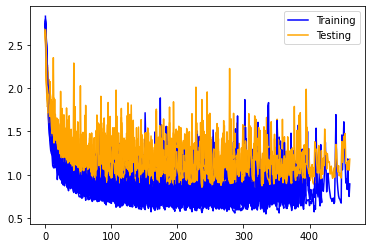

In [10]:
for i, history in enumerate(histories):
    pl.plot(history.history['loss'], label='Training', color="blue")
    pl.plot(history.history['val_loss'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

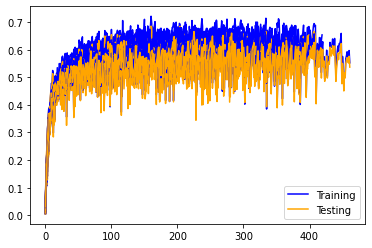

In [11]:
for i, history in enumerate(histories):
    pl.plot(history.history['f1_score_train'], label='Training', color="blue")
    pl.plot(history.history['f1_score_val'], label='Testing', color="orange")
    
    if i == 0:
        pl.legend()
        
    pl.grid()

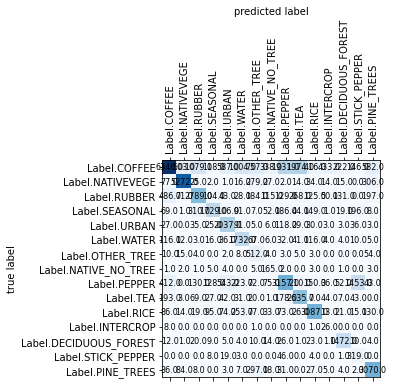

In [12]:
plot_confusion_matrix(conf_matrix, labels)

In [13]:
recall, precision, fscore = recall_precision_fscore_from_confusion_matrix(conf_matrix)

print("Precisions: ", precision)
print("Mean precision: ", np.mean(precision))
print("\nRecalls: ", recall)
print("Mean recall: ", np.mean(recall))
print("\nF-Score: ", fscore)
print("Mean f-score: ", np.mean(fscore))

Precisions:  [0.80543216 0.8819003  0.62088157 0.76301853 0.58166762 0.49613291
 0.22328827 0.19320843 0.53381806 0.50219173 0.7394012  0.04126984
 0.75409836 0.14304933 0.6969353 ]
Mean precision:  0.5317529074023503

Recalls:  [0.38610367 0.86653517 0.59088983 0.58254717 0.83210784 0.78727273
 0.82580645 0.859375   0.47232196 0.79848485 0.7686753  0.72222222
 0.91315136 0.7975     0.85467706]
Mean recall:  0.737178041915763

F-Score:  [0.52198232 0.87415022 0.60551455 0.66068017 0.68470588 0.60868037
 0.35152763 0.31548757 0.50119067 0.61659062 0.75375412 0.07807808
 0.82603816 0.24258555 0.76778792]
Mean f-score:  0.5605835884251813
